In [41]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import yfinance as yf

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

import datetime

In [42]:
ticker =  'GOOG'

def get_data(ticker, start, end):
    data =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
    data = pd.DataFrame(data)
    data.rename(columns = {'Adj Close':ticker}, inplace=True)
    data.drop(['Close', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    return data

In [43]:
start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2017, 12, 31)

stock = get_data(ticker, start, end)
stock.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,GOOG,Volume
Date,,,,,
2009-01-02,7.686190,8.015456,7.608980,8.003003,144961322
2009-01-05,7.995033,8.250077,7.845593,8.170624,196293007
2009-01-06,8.293414,8.488184,8.129279,8.320313,257971329
2009-01-07,8.177349,8.241857,7.938993,8.020188,180453860
2009-01-08,7.927287,8.099391,7.903874,8.099391,144567852


In [44]:
start_test = datetime.datetime(2018, 1, 1)
end_test = datetime.datetime(2023, 12, 31)
test_data = get_data(ticker, start_test, end_test)
test_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,GOOG,Volume
Date,,,,,
2018-01-02,52.417000,53.347000,52.261501,53.250000,24752000
2018-01-03,53.215500,54.314499,53.160500,54.124001,28604000
2018-01-04,54.400002,54.678501,54.200100,54.320000,20092000
2018-01-05,54.700001,55.212502,54.599998,55.111500,25582000
2018-01-08,55.111500,55.563499,55.081001,55.347000,20952000
...,...,...,...,...,...
2023-12-22,142.130005,143.250000,142.054993,142.720001,18494700
2023-12-26,142.979996,143.945007,142.500000,142.820007,11170100
2023-12-27,142.830002,143.320007,141.050995,141.440002,17288400


In [45]:
features = []

sc = MinMaxScaler(feature_range=(0,1))
def preprocess(data):
    for leng in [10,20,30]:
        sma = ta.sma(data[ticker], length=leng)
        data['SMA_'+f'{leng}'] = sma

    for leng in [10,20,30]:
        ema = ta.ema(data[ticker], length=leng)
        data['EMA_'+f'{leng}'] = ema

    data['RSI_'+f'{14}'] = ta.rsi(data[ticker])

    stoch = ta.stoch(data['High'], data['Low'], data[ticker])
    stochk = stoch['STOCHk_14_3_3']
    data = data[13:]
    data['Stoch_Oscillator'] = stochk

    williams_r = ta.willr(data['High'], data['Low'], data[ticker])
    data['Williams_%R'] = williams_r

    adx = ta.adx(data['High'], data['Low'], data[ticker])
    data['ADX'] = adx['ADX_14']

    data['returns'] = np.log(data[ticker] / data[ticker].shift(1))
    data.dropna(inplace=True)
    data['direction'] = [1 if data.returns[i]>0 else 0 for i in range(len(data))]

    features = ([col for col in data.columns if col not in ['Open', 'High', 'Low', ticker, 'returns', 'Volume', 'direction']])
    data[features] = sc.fit_transform(data[features])

    return data.dropna(axis=0)


stock = preprocess(stock)
test_data = preprocess(test_data)

features = ([col for col in stock.columns if col not in ['Open', 'High', 'Low', ticker, 'returns', 'Volume', 'direction']])


/tmp/ipykernel_26194/368033129.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Stoch_Oscillator'] = stochk
/tmp/ipykernel_26194/368033129.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Williams_%R'] = williams_r
/tmp/ipykernel_26194/368033129.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

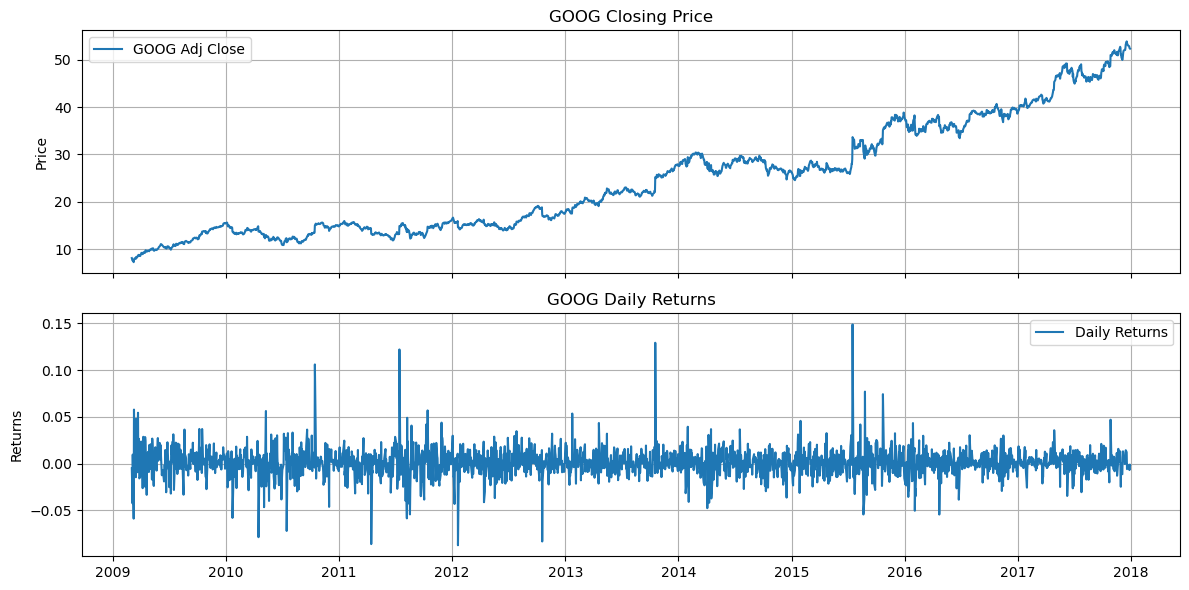

In [46]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Returns', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()
plt.tight_layout();

In [47]:
stock[features].head()

,SMA_10,SMA_20,SMA_30,EMA_10,EMA_20,EMA_30,RSI_14,Stoch_Oscillator,Williams_%R,ADX
Date,,,,,,,,,,
2009-03-03,0.013444,0.013077,0.004522,0.011315,0.008297,0.005295,0.310181,0.064869,0.073387,0.103468
2009-03-04,0.011560,0.012469,0.005208,0.009453,0.007204,0.004718,0.268846,0.033558,0.073383,0.127423
2009-03-05,0.009521,0.011414,0.005257,0.006590,0.005504,0.003693,0.194873,0.042947,0.049710,0.176759
2009-03-06,0.007433,0.010139,0.005296,0.004543,0.004122,0.002841,0.222338,0.093049,0.218459,0.234305
2009-03-09,0.005274,0.007869,0.004654,0.001086,0.001926,0.001397,0.135861,0.074775,0.020469,0.292035


In [48]:
models = {
 'log_reg': linear_model.LogisticRegression(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100)
}

models_impl = {}

for model in models.keys():
    models_impl[model] = models[model].fit(stock[features], stock['direction'])

for model in models.keys():
    test_data['y_pred_' + model] = models[model].predict(test_data[features])

In [49]:
target_names = ['direction_up', 'direction_down']

def measure_classification():
    for model in models.keys():
        y_true = test_data['direction']
        y_pred = test_data['y_pred_'+model]
        print(f'====== {model} Classification report ======')
        print(classification_report(y_true, y_pred, target_names=target_names))
        print(confusion_matrix(y_true, y_pred, labels=[1, 0]))

In [50]:
measure_classification()

====== log_reg Classification report ======
                precision    recall  f1-score   support

  direction_up       0.83      0.78      0.80       686
direction_down       0.82      0.86      0.84       783

      accuracy                           0.82      1469
     macro avg       0.82      0.82      0.82      1469
  weighted avg       0.82      0.82      0.82      1469

[[673 110]
 [151 535]]
====== svm Classification report ======
                precision    recall  f1-score   support

  direction_up       0.81      0.79      0.80       686
direction_down       0.82      0.84      0.83       783

      accuracy                           0.81      1469
     macro avg       0.81      0.81      0.81      1469
  weighted avg       0.81      0.81      0.81      1469

[[655 128]
 [144 542]]
====== random_forest Classification report ======
                precision    recall  f1-score   support

  direction_up       0.82      0.79      0.80       686
direction_down       0.82    